In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from collections import Counter

%matplotlib inline

# Why the 'AI revolution' is really a deep learning revolution

## Introduction

We often hear that there's been an explosion in AI research, that AI is advancing a breakneck speed.
However, when we look at computer science publications we see no evidence of such changes in the AI research landscape.
Infact many traditional fields such as logic programming, evolutionary algorithms, bayesian statistics are on the decline.
What we do see is a unprecidented explosion of publications in the field of deep learning.
Since 2012 deep learning has gone from an unused term to a phrase that dominates the landscape.
We estimate that more than one fith of AI or similar publications are now part of a deep learning gold rush.

## Dataset

The study uses the Kaggle Arxiv dataset. 
A collection of metadata about 41000 publications since 1995 tagged with:
* Machine Learning
* Computation and Language
* Artificial Inteligence
* Computer Vision
* Neural and Evolutionary Computing

IMPORTANT NOTE: We need to reproduce this data ourselves in order to completely trust it. Volunteers are welcome.

You can download the dataset [here](https://www.kaggle.com/neelshah18/arxivdataset/activity).

In [95]:
data = pd.read_json('./data.jsonlines', lines=True)
data = data[data.catagories.apply(lambda records: "cs.AI" in records)]
data['year'] = data['created'].str.split('-').apply(lambda x: int(x[0]))
data.head()

,abstract,authors,catagories,comments,created,id,journal-ref,license,title,updated,year
2,The intelligent acoustic emission locator is...,"[{'keyname': 'Kosel', 'forenames': ['T.']}, {'...","[cs.NE, cs.AI]","5 pages, 5 eps figures, uses IEEEtran.cls",2007-04-01,0704.0047,None,None,Intelligent location of simultaneously active ...,None,2007
3,Part I describes an intelligent acoustic emi...,"[{'keyname': 'Kosel', 'forenames': ['T.']}, {'...","[cs.NE, cs.AI]","5 pages, 7 eps figures, uses IEEEtran.cls",2007-04-01,0704.0050,None,None,Intelligent location of simultaneously active ...,None,2007
14,This paper discusses the benefits of describ...,"[{'keyname': 'Gershenson', 'forenames': ['Carl...","[cs.IT, cs.AI, math.IT, q-bio.PE]","16 pages. Extended version, three more laws of...",2007-04-02,0704.0304,"Minai, A., Braha, D., and Bar-Yam, Y., eds. Un...",http://arxiv.org/licenses/nonexclusive-distrib...,The World as Evolving Information,2010-10-13,2007
38,Advances in semiconductor technology are con...,"[{'keyname': 'Abubakr', 'forenames': ['Mohd']}...","[cs.NE, cs.AI]","4 pages, 2 figures. Submitted to SASO 2007",2007-04-07,0704.0985,None,None,Architecture for Pseudo Acausal Evolvable Embe...,None,2007
40,Ordinal regression is an important type of l...,"[{'keyname': 'Cheng', 'forenames': ['Jianlin']}]","[cs.LG, cs.AI, cs.NE]",8 pages,2007-04-08,0704.1028,None,None,A neural network approach to ordinal regression,None,2007


In [96]:
# examine the most popular tags
tag_counts = Counter(row['term'] for tag in tags for row in tag if row['term'][:2] == 'cs')
sorted(tag_counts.items(), key = lambda x: x[1], reverse=True)[:5]

[('cs.CV', 13902),
 ('cs.LG', 13735),
 ('cs.AI', 10481),
 ('cs.CL', 6417),
 ('cs.NE', 3819)]

## Preprocessing

Create some columns in the dataset to mark the presence of some key words.

In [97]:
data['is_deep'] = data['title'].str.contains('deep', case=False)
data['is_adversarial'] = data['title'].str.contains('adversarial', case=False)
data['is_reinforcement'] = data['title'].str.contains('reinforcement', case=False)
data['is_convolutional'] = data['title'].str.contains('convolutional', case=False)
# data['is_bayesian'] = data['title'].str.contains('bayesian', case=False)
data['is_ai'] = data['title'].str.contains(' ai ', case=False)
data['is_artificial_intelligence'] = data['title'].str.contains('artificial intelligence', case=False)
# data['is_bandit_algorithm'] = data['title'].str.contains('bandit algorithm', case=False)
data['is_logic'] = data['title'].str.contains('logic', case=False)
# data['is_algorithm'] = data['title'].str.contains('algorithm', case=False)
data['is_evolutionary'] = data['title'].str.contains('evolutionary', case=False)
# data['is_fuzzy_logic'] = data['title'].str.contains('fuzzy logic', case=False)

## Results

### Word counts, in titles, per year

Fuzzy logic and logical programming were staples of AI research through the late ninties and early 21st century.
Below we can see a steady rate of publications containing the word `logic` in the title. 
There has been a gradual decline since 2012.

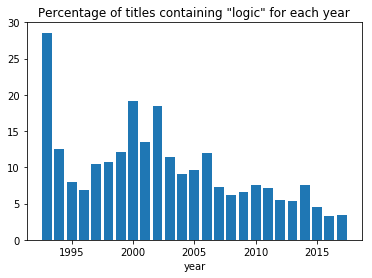

In [98]:
counts = {}
for year, group in data.groupby('year'):
    counts[year] = {'freq': sum(group['is_logic'] > 0), 'total': len(group)}
    
hist = []
years = sorted(counts.keys())    
for year in years:
    hist.append(100 * counts[year]['freq'] / counts[year]['total'])

plt.xlabel('year')
plt.title('Percentage of titles containing "logic" for each year')
plt.bar(years, hist)
plt.show()

Similarly evolutionary algorithms peaked in 2005 with a gradual rise and fall either side.

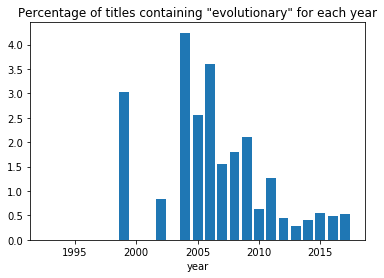

In [99]:
counts = {}
for year, group in data.groupby('year'):
    counts[year] = {'freq': sum(group['is_evolutionary'] > 0), 'total': len(group)}
    
hist = []
years = sorted(counts.keys())    
for year in years:
    hist.append(100 * counts[year]['freq'] / counts[year]['total'])

plt.xlabel('year')
plt.title('Percentage of titles containing "evolutionary" for each year')
plt.bar(years, hist)
plt.show()

In stark contrast with the previous two examples titles containing the word deep have exploded.

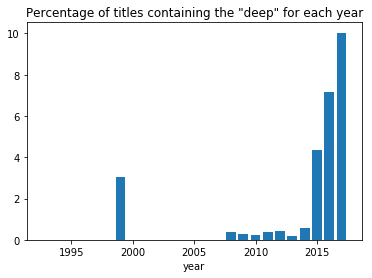

In [100]:
counts = {}
for year, group in data.groupby('year'):
    counts[year] = {
        'freq': sum(group['is_deep']),
        'total': len(group)
    }

hist = []
years = sorted(counts.keys())
for year in years:
    hist.append(100 * counts[year]['freq'] / counts[year]['total'])

plt.xlabel('year')
plt.title('Percentage of titles containing the "deep" for each year')

plt.bar(years, hist)
plt.show()

When we examine several words indicative of deep learning research such as `deep`, `adversarial` and `convolutional` we see what appears to be exponential growth from around 2012.

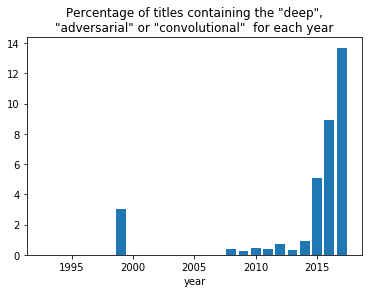

In [101]:
counts = {}
for year, group in data.groupby('year'):
    counts[year] = {
        'freq': sum(group['is_deep'] | group['is_adversarial'] | group['is_convolutional']),
        'total': len(group)
    }

hist = []
years = sorted(counts.keys())
for year in years:
    hist.append(100 * counts[year]['freq'] / counts[year]['total'])
    
plt.bar(years, hist)
plt.xlabel('year')
plt.title('Percentage of titles containing the "deep",\n"adversarial" or "convolutional"  for each year')
plt.show()

As a side note observe that the terms such as `artificial_intelligence` or `ai` are not commonly used in titles.
139 out of 41000 titles contain one of these terms (fewer than 0.5%)

In [102]:
len(data[data['is_artificial_intelligence'] | data['is_ai']]), len(data)

(133, 12218)

## Which words have changed?

Next we examine which words have seen the biggest increase or decreate in usage pre and post 2012

In [103]:
base_cv = CountVectorizer(analyzer='word', stop_words='english', ngram_range=[1, 2])
base_cv = base_cv.fit(data['title'])

cv = CountVectorizer(analyzer='word', stop_words='english', ngram_range=[1,2], vocabulary=base_cv.vocabulary_.keys())
arr = cv.fit_transform(data[data['year'] < 2012]['title'])
old_counts = np.array(np.sum(arr, axis=0)).flatten() / arr.shape[0]

cv = CountVectorizer(analyzer='word', stop_words='english', ngram_range=[1, 2], vocabulary=base_cv.vocabulary_.keys())
arr = cv.fit_transform(data[data['year'] > 2012]['title'])
new_counts = np.array(np.sum(arr, axis=0)).flatten()  / arr.shape[0]

In [104]:
diff = 100 * (new_counts - old_counts)
keys = list(base_cv.vocabulary_.keys())
arg_diff = np.argsort(diff)

### Pre - 2012

In [105]:
pd.DataFrame(
    [(keys[i], 100*old_counts[i], 100*new_counts[i], new_counts[i]/old_counts[i]) for i in arg_diff[:10]], 
    columns = ['word', 'old freq (%)', 'new freq (%)', 'ratio']
)

,word,old freq (%),new freq (%),ratio
0,logic,6.28125,3.016859,0.480296
1,constraint,3.21875,1.204208,0.374123
2,programming,4.12500,2.307010,0.559275
3,systems,4.40625,2.966155,0.673170
4,programs,2.34375,0.988718,0.421853
5,logic programs,1.68750,0.342249,0.202814
6,algorithms,3.03125,1.812651,0.597988
7,complexity,2.25000,1.077450,0.478866
8,logics,1.59375,0.469007,0.294279
9,information,3.43750,2.332362,0.678505


### Post - 2012

In [106]:
pd.DataFrame(
    [(keys[i], 100*old_counts[i], 100*new_counts[i], new_counts[i]/old_counts[i]) for i in arg_diff[-10:]],
    columns = ['word', 'old freq (%)', 'new freq (%)', 'ratio']
)

,word,old freq (%),new freq (%),ratio
0,neural networks,1.03125,2.484472,2.409185
1,using,6.21875,7.732285,1.243383
2,probabilistic,1.96875,3.790087,1.925124
3,bayesian,1.81250,3.688680,2.035134
4,neural,2.40625,4.956268,2.059748
5,reinforcement learning,1.03125,3.815439,3.699820
6,reinforcement,1.09375,3.878819,3.546348
7,networks,3.43750,8.112562,2.360018
8,deep,0.15625,5.006972,32.044619
9,learning,7.68750,15.502599,2.016598


Words such as:
* logic
* programming
* algorithms
* evolutionary

used to appear in between 1% and 5% or titles.
Their usage has generally been cut by a half or a third.

Words (and word pairs) such as:
* deep learning
* deep
* convolutional

have increased dramatically. In some cases they appear over 100 times more often than after 2012 compared to before 2012.

# Conclusions

The computer science AI landscape has transformed since 2012.
Pre 2012 there were a braod range of topics such as `fuzzy logic`, `logic programming`, `evolutionary algorithms`.
There each had a presence in 1%-5% of publications.
Frequently domain specific algorithms were published that solve niche problems such as face detection or optimal searches.

Post 2012 the landscape has become much more monolithic with one topic, deep learning, dominating the landscape.
Deep learning has come from obscurity to ubiquity, the subject of approximately one in five publications whilst still growings in its share.
Following the incredibly rapid trends demonstated above deep learning is on course to saturate AI research in the next few years, although this is far from a certainty.

When reading about AI revolutions in the press we need to remember in reality it is a deep learning revolution.
Deep learning is not a silver bullet, while it will continue to make huge strides in some areas (very high dimensional proplems with huge datasets) it is unliekly to have any impact in others. 

If we do not unsterstand the strengths and weeknesses of deep learning and communicate them to manage expectations we risk a damaging gap between expectation and reality, between researchers and technologists which could be harmful for future progress. 